In [1]:
import sys
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import os
import itertools
import socket
from datetime import datetime
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import time
import holidays
import pycountry

import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from IPython.display import display
from IPython.display import clear_output

In [2]:
from catboost import CatBoostClassifier
from catboost.utils import get_gpu_device_count

# Check available GPUs
gpu_count = get_gpu_device_count()
if gpu_count > 0:
    print(f"GPU is available with {gpu_count} GPU(s).")
else:
    print("No GPU detected. Ensure your setup is correct.")

# Test CatBoost with GPU
try:
    model = CatBoostClassifier(task_type="GPU", devices='0')  # Specify GPU
    device = 'cuda'
    print("CatBoost can use the GPU.")
        
except Exception as e:
    device = 'cpu'
    print(f"Error: {e}")

No GPU detected. Ensure your setup is correct.
CatBoost can use the GPU.


In [3]:
# Declare important variables
train_path = 'train.csv'
test_path = 'test.csv'
submission_path = 'sample_submission.csv'
target_variable = 'num_sold'
SEED = 69
skip_hypertuning = True
cat_encoder_type = 'OneHotEncoder' #OneHotEncoder, FrequencyEncoder, None

In [4]:
def load_dataframes(path1: str, path2: str, format1: str = "csv", format2: str = "csv") -> tuple:

    loaders = {
        "csv": pd.read_csv,
        "excel": pd.read_excel,
        "json": pd.read_json,
    }

    if format1 not in loaders or format2 not in loaders:
        raise ValueError("Unsupported format. Supported formats: 'csv', 'excel', 'json'.")

    # Load the dataframes using appropriate loaders
    df1 = loaders[format1](path1)
    df2 = loaders[format2](path2)

    print(f"Loading data from {os.getcwd()}")
    
    return df1, df2

In [5]:
df_train, df_test = load_dataframes(train_path,test_path)

Loading data from C:\Users\zchodan\OneDrive - Franklin Templeton\Documents\Python\Kaggle\Playground Series\s5e1 - Sticker Sales


In [6]:
df_train_id = df_test['id']
df_test_id = df_train['id']

In [7]:
#plot_kde_grid(df_train,n_cols=4,figsize=(12,8))

In [8]:
#plot_kde_grid(df_solve,n_cols=4,figsize=(9,6))

In [9]:
def get_num_cols(df: pd.DataFrame):
    num_cols = df.select_dtypes(include=['number']).columns.to_list()
    
    return num_cols

def get_cat_cols(df: pd.DataFrame):
    cat_cols = df.select_dtypes(include=['object', 'string', 'category']).columns.tolist()  

    return cat_cols

In [10]:
def describe_dataframe(df_to_use: pd.DataFrame, name: str = 'DataFrame', nrows: int = 3, plots: bool = False, info: bool = True) -> None:
    '''
    Function to describe the DataFrame with summary statistics, missing value count,
    unique value count, and duplicate count. It also displays plots for missing and unique values.
    
    Parameters:
    - df: The DataFrame to describe.
    - name: The name to display in the summary (default is 'DataFrame').
    - nrows: The number of rows to display from the top and bottom (default is 3).
    - plots: Whether to display bar plots for missing and unique values (default is False).
    - info: Whether to display the styled DataFrame (default is True).
    '''

    df = df_to_use.copy()   
    
    # Create summary DataFrame
    inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    
    # Missing values
    df_missing = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missing'})
    df_missing['pct_missing'] = (df_missing['missing'] / df.shape[0]) * 100
    
    # Unique values
    df_unique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index':'column', 0:'unique'})
    
    # Combine summary information
    inf['missing'] = df_missing['missing']
    inf['pct_missing'] = df_missing['pct_missing']
    inf['unique'] = df_unique['unique']
    inf['duplicate'] = df.duplicated().sum()
    inf['count'] = df.shape[0]

    # Descriptive statistics
    desc = pd.DataFrame(df.describe(include='all').transpose())
    if 'min' in desc.columns.tolist():
        inf['min'] = desc['min'].values
        inf['max'] = desc['max'].values
        inf['avg'] = desc['mean'].values
        inf['std dev'] = desc['std'].values
    if 'top' in desc.columns.tolist():
        inf['top value'] = desc['top'].values
        inf['Freq'] = desc['freq'].values 
    
    # Display styled DataFrame
    if info:
        display(inf.style.background_gradient(subset=['missing','pct_missing'], cmap='Reds').background_gradient(subset='unique', cmap='Greens'))

    if nrows != 0 :
        # Display top and bottom nrows of the DataFrame
        print(f"\n---------- {name} Overview ----------:")
        print(f"{name} has {df.shape[0]} rows and {df.shape[1]} columns\n")
        display(df.head(nrows))
        display(df.tail(nrows))
    
    # Plot missing values if any
    if plots and df_missing['missing'].sum() > 0:
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_missing[df_missing['missing'] > 0], x='column', y='missing', ax=ax)
        ax.set_title(f'{name} missing Values') 
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()
    
        # Plot unique values
        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_unique[df_unique['unique'] > 0], x='column', y='unique', ax=ax)
        ax.set_title(f'{name} Unique Values')
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()

In [11]:
describe_dataframe(df_train, name='Insurance Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,id,int64,0,0.000000,230130,0,230130,0.000000,230129.000000,115064.500000,66432.953062,nan,nan
1,date,object,0,0.000000,2557,0,230130,nan,nan,nan,nan,2010-01-01,90
2,country,object,0,0.000000,6,0,230130,nan,nan,nan,nan,Canada,38355
3,store,object,0,0.000000,3,0,230130,nan,nan,nan,nan,Discount Stickers,76710
4,product,object,0,0.000000,5,0,230130,nan,nan,nan,nan,Holographic Goose,46026
5,num_sold,float64,8871,3.854778,4037,0,230130,5.000000,5939.000000,752.527382,690.165445,nan,nan


<Figure size 1000x600 with 0 Axes>

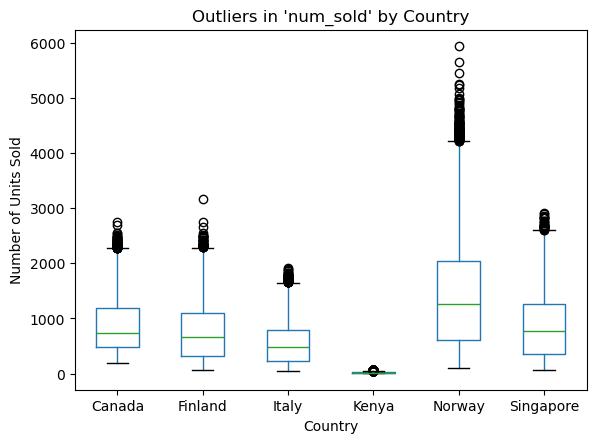

In [12]:
plt.figure(figsize=(10, 6))
df_train.boxplot(column=target_variable, by='country', grid=False)
plt.title("Outliers in 'num_sold' by Country")
plt.suptitle("")  # Removes the default matplotlib title
plt.ylabel('Number of Units Sold')
plt.xlabel('Country')
plt.show()

In [13]:
# Log to compress outliers
df_train['y'] = np.log(df_train[target_variable])
df_train = df_train.drop(target_variable, axis=1)

<Figure size 1000x600 with 0 Axes>

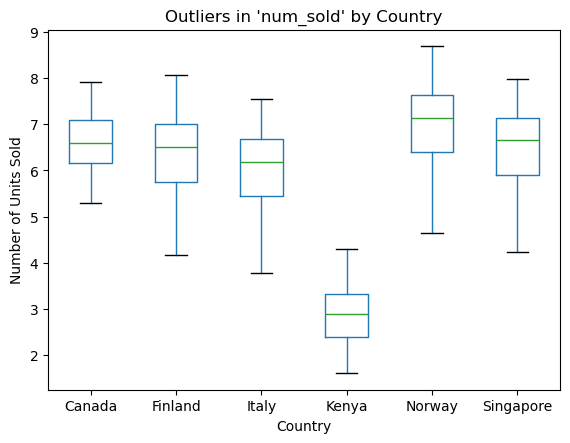

In [14]:
plt.figure(figsize=(10, 6))
df_train.boxplot(column='y', by='country', grid=False)
plt.title("Outliers in 'num_sold' by Country")
plt.suptitle("")  # Removes the default matplotlib title
plt.ylabel('Number of Units Sold')
plt.xlabel('Country')
plt.show()

In [15]:
def clean_dataframe(df_to_use: pd.DataFrame, impute_num_nulls: bool = True, fill_cat_nulls: bool = True) -> None:
    df = df_to_use.copy()

    # Convert date column from object to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Filter columns where the type is either 'float' or 'int' and there are missing values
    numeric_cols = df.select_dtypes(include=['number']).columns
    missing_numeric_columns = [
        col for col in numeric_cols if df[col].isnull().sum() > 0
    ]

    # Target field 'num_sold' is missing some values, we do not want to impute them
    if 'y' in missing_numeric_columns:
        missing_numeric_columns.remove('y')
    
    # Fill nulls in numeric columns with the median
    if impute_num_nulls:       
        for column in missing_numeric_columns:
            mdn = df[column].median()
            df[column] = df[column].fillna(mdn)

    
    # Get category columns
    if fill_cat_nulls:
        cat_cols = df.select_dtypes(include=['object', 'string','category']).columns.tolist()  
        # Fill missing values in object columns
        for column in cat_cols:
            df[column] = df[column].fillna('None')
    
    return df

In [16]:
df_train = clean_dataframe(df_train, impute_num_nulls = True, fill_cat_nulls=False)
df_test = clean_dataframe(df_test, impute_num_nulls = True, fill_cat_nulls=False)

In [17]:
describe_dataframe(df_train, name='Insurance Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev,top value,Freq
0,id,int64,0,0.000000,230130,0,230130,0.000000,230129.000000,115064.500000,66432.953062,nan,nan
1,date,datetime64[ns],0,0.000000,2557,0,230130,2010-01-01 00:00:00,2016-12-31 00:00:00,2013-07-02 00:00:00,nan,nan,nan
2,country,object,0,0.000000,6,0,230130,nan,nan,nan,nan,Canada,38355
3,store,object,0,0.000000,3,0,230130,nan,nan,nan,nan,Discount Stickers,76710
4,product,object,0,0.000000,5,0,230130,nan,nan,nan,nan,Holographic Goose,46026
5,y,float64,8871,3.854778,4037,0,230130,1.609438,8.689296,5.925537,1.541007,nan,nan


In [18]:
df_train = df_train.dropna(subset='y')

In [19]:
def get_holiday_name(country_code, date_obj):
    try:
        country_holiday = holidays.CountryHoliday(country_code, years=date_obj.year)
        return country_holiday.get(date_obj)
    except Exception as e:
        print(f"Error for country code {country_code} and date {date_obj}: {e}")
        return 'Invalid Holiday'
    return country_holiday.get(date_obj)

def get_country_code(country_name):
    try:
        country = pycountry.countries.get(name=country_name)
        return country.alpha_2  
    except KeyError:
        print(f"Unknown Country: {country_name}")
        return None

def get_holiday_for_row(row):
    country_code = get_country_code(row['country'])
    if country_code is None:
        return 'Unknown Country'     
    try:
        date_obj = row['date']
    except ValueError:
        print(f"Invalid Date: {row['date']}")
        return 'Invalid Date'

    return get_holiday_name(country_code, date_obj)


for df in [df_train, df_test]:
    df['holiday'] = df.apply(get_holiday_for_row, axis=1)


In [20]:
for df in [df_train, df_test]:
    df['Year'] = df['date'].dt.year
    df['Quarter'] = df['date'].dt.quarter
    df['Month'] = df['date'].dt.month
    df['Day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.day_name()
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week

    df['day_sin'] = np.sin(2 * np.pi * df['Day'] / 365.0)
    df['day_cos'] = np.cos(2 * np.pi * df['Day'] / 365.0)
    df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12.0)
    df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12.0)
    df['year_sin'] = np.sin(2 * np.pi * df['Year'] / 7.0)
    df['year_cos'] = np.cos(2 * np.pi * df['Year'] / 7.0)
    df['Group']=(df['Year']-2010)*48+df['Month']*4+df['Day']//7


    df['Quarter'] = df['Quarter'].astype('str')
    df['Month'] = df['Month'].astype('str')
    df['day_of_week'] = df['day_of_week'].astype('str')
    df['day_of_year'] = df['day_of_week'].astype('str')
    df['week_of_year'] = df['week_of_year'].astype('str')


In [21]:
RMV = ['y','id','date']
FEATURES = [c for c in df.columns if not c in RMV]
combined = pd.concat([df_train,df_test],axis=0,ignore_index=True)

CATS = []
HIGH_CARDINALITY = []
print(f"THE {len(FEATURES)} BASIC FEATURES ARE:")

for c in FEATURES:
    ftype = "numerical"
    if combined[c].dtype=="object":
        CATS.append(c)
        combined[c] = combined[c].fillna("NAN")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        ftype = "categorical"
    if combined[c].dtype=="int64":
        combined[c] = combined[c].astype("int32")
    elif combined[c].dtype=="float64":
        combined[c] = combined[c].astype("float32")

    n = combined[c].nunique()
    print(f"{c} ({ftype}) with {n} unique values")
    if n>=9: HIGH_CARDINALITY.append(c)
    
df_train = combined.iloc[:len(df_train)].copy()
df_test = combined.iloc[len(df_train):].reset_index(drop=True).copy()

print("\nTHE FOLLOWING HAVE 9 OR MORE UNIQUE VALUES:", HIGH_CARDINALITY )


df_train = df_train.drop(['date','id'], axis=1)
df_test = df_test.drop(['date','id'], axis=1)


THE 18 BASIC FEATURES ARE:
country (categorical) with 6 unique values
store (categorical) with 3 unique values
product (categorical) with 5 unique values
holiday (categorical) with 75 unique values
Year (numerical) with 10 unique values
Quarter (categorical) with 4 unique values
Month (categorical) with 12 unique values
Day (numerical) with 31 unique values
day_of_week (categorical) with 7 unique values
day_of_year (categorical) with 7 unique values
week_of_year (categorical) with 53 unique values
day_sin (numerical) with 31 unique values
day_cos (numerical) with 31 unique values
month_sin (numerical) with 8 unique values
month_cos (numerical) with 8 unique values
year_sin (numerical) with 7 unique values
year_cos (numerical) with 4 unique values
Group (numerical) with 481 unique values

THE FOLLOWING HAVE 9 OR MORE UNIQUE VALUES: ['holiday', 'Year', 'Month', 'Day', 'week_of_year', 'day_sin', 'day_cos', 'Group']


In [22]:
describe_dataframe(df_train, name='Sales Data', nrows=0, plots=False, info=True)

,column,type,missing,pct_missing,unique,duplicate,count,min,max,avg,std dev
0,country,int32,0,0.000000,6,0,221259,0.000000,5.000000,2.537524,1.705006
1,store,int32,0,0.000000,3,0,221259,0.000000,2.000000,1.018770,0.815477
2,product,int32,0,0.000000,5,0,221259,0.000000,4.000000,1.920396,1.383711
3,y,float64,0,0.000000,4037,0,221259,1.609438,8.689296,5.925537,1.541007
4,holiday,int32,0,0.000000,72,0,221259,0.000000,71.000000,4.804198,5.545566
5,Year,int32,0,0.000000,7,0,221259,2010.000000,2016.000000,2013.010748,1.996617
6,Quarter,int32,0,0.000000,4,0,221259,0.000000,3.000000,1.509141,1.120440
7,Month,int32,0,0.000000,12,0,221259,0.000000,11.000000,5.524643,3.460923
8,Day,int32,0,0.000000,31,0,221259,1.000000,31.000000,15.728576,8.800895
9,day_of_week,int32,0,0.000000,7,0,221259,0.000000,6.000000,2.990183,1.999716


In [23]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='date',y='y',hue='product')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);`

In [24]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='Day of Year',y='y')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);

In [25]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='Week of Year',y='y')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);

In [26]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='Month',y='y')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);

In [27]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='Year',y='y', hue='country')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);

In [28]:
# sns.set(rc={'figure.figsize':(24,8)})
# ax=sns.lineplot(data=df_train,x='Day of Year Sin',y='y')
# ax.axes.set_title("\nBasic Time Series of Sales\n",fontsize=20);

In [29]:
def target_encode(train, valid, test, col, target="y", kfold=5, smooth=20, agg="mean"):
             
    train['kfold'] = ((train.index) % kfold)
    col_name = '_'.join(col)
    train[f'TE_{agg.upper()}_' + col_name] = 0.
    for i in range(kfold):
        
        df_tmp = train[train['kfold']!=i]       
        if agg=="mean": mn = train[target].mean()
        elif agg=="median": mn = train[target].median()
        elif agg=="min": mn = train[target].min()
        elif agg=="max": mn = train[target].max()
        elif agg=="nunique": mn = 0
        df_tmp = df_tmp[col + [target]].groupby(col).agg([agg, 'count']).reset_index()
        df_tmp.columns = col + [agg, 'count']
        if agg=="nunique":
            df_tmp['TE_tmp'] = df_tmp[agg] / df_tmp['count']
        else:
            df_tmp['TE_tmp'] = ((df_tmp[agg]*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
        df_tmp_m = train[col + ['kfold', f'TE_{agg.upper()}_' + col_name]].merge(df_tmp, how='left', left_on=col, right_on=col)
        df_tmp_m.loc[df_tmp_m['kfold']==i, f'TE_{agg.upper()}_' + col_name] = df_tmp_m.loc[df_tmp_m['kfold']==i, 'TE_tmp']
        train[f'TE_{agg.upper()}_' + col_name] = df_tmp_m[f'TE_{agg.upper()}_' + col_name].fillna(mn).values  
    
    df_tmp = train[col + [target]].groupby(col).agg([agg, 'count']).reset_index()
    if agg=="mean": mn = train[target].mean()
    elif agg=="median": mn = train[target].median()
    elif agg=="min": mn = train[target].min()
    elif agg=="max": mn = train[target].max()
    elif agg=="nunique": mn = 0
    df_tmp.columns = col + [agg, 'count']
    
    if agg=="nunique":
        df_tmp['TE_tmp'] = df_tmp[agg] / df_tmp['count']
    else:
        df_tmp['TE_tmp'] = ((df_tmp[agg]*df_tmp['count'])+(mn*smooth)) / (df_tmp['count']+smooth)
        
    valid_col_df = valid[col]
    df_tmp_m = valid_col_df.merge(df_tmp, how='left', left_on=col, right_on=col).reset_index(drop=True)
    valid[f'TE_{agg.upper()}_' + col_name] = df_tmp_m['TE_tmp'].fillna(mn).values
    valid[f'TE_{agg.upper()}_' + col_name] = valid[f'TE_{agg.upper()}_' + col_name].astype("float32")
    
    test_col_df = test[col]
    df_tmp_m = test_col_df.merge(df_tmp, how='left', left_on=col, right_on=col).reset_index(drop=True)
    test[f'TE_{agg.upper()}_' + col_name] = df_tmp_m['TE_tmp'].fillna(mn).values
    test[f'TE_{agg.upper()}_' + col_name] = test[f'TE_{agg.upper()}_' + col_name].astype("float32")

    train = train.drop('kfold', axis=1)
    train[f'TE_{agg.upper()}_' + col_name] = train[f'TE_{agg.upper()}_' + col_name].astype("float32")

    return(train, valid, test)

In [30]:
# lists2 = [['Annual Income', 'Health Score'], ['Credit Score', 'Health Score'], ['Customer Feedback', 'Gender', 'Marital Status', 'Occupation', 'Smoking Status', 'year'], ['Exercise Frequency', 'Health Score'], ['Health Score', 'Marital Status'], ['Education Level', 'Gender', 'Health Score'], ['Health Score', 'Occupation'], ['Age', 'Health Score'], ['Health Score', 'dow'], ['Age', 'Exercise Frequency', 'Location'], ['Health Score', 'Smoking Status', 'month'], ['Health Score', 'Location', 'Policy Type'], ['Health Score', 'Insurance Duration'], ['Health Score', 'Number of Dependents'], ['Customer Feedback', 'Exercise Frequency', 'Previous Claims', 'Property Type', 'dow'], ['Customer Feedback', 'Health Score'], ['Health Score', 'Property Type'], ['Health Score', 'day', 'seconds'], ['Health Score', 'year'], ['Age', 'Gender', 'Insurance Duration', 'year']]
# print(f"We have {len(lists2)} powerful combination of columns!")
# print(lists2)
lists2 = []

In [32]:
import time
from xgboost import XGBRegressor
import xgboost as xgb, time
from sklearn.model_selection import TimeSeriesSplit
print(f"Using XGBoost version",xgb.__version__)


start = time.time()

FOLDS = 5
tscv = TimeSeriesSplit(n_splits=FOLDS)

oof = np.zeros(len(df_train))
pred = np.zeros(len(df_test))

for i, (train_index, test_index) in enumerate(tscv.split(df_train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = df_train.loc[train_index,FEATURES+["y"] ].copy()
    y_train = df_train.loc[train_index,"y"]
    x_valid = df_train.loc[test_index,FEATURES].copy()
    y_valid = df_train.loc[test_index,"y"]
    x_test = df_test[FEATURES].copy()

    start = time.time()
    print(f"FEATURE ENGINEER {len(FEATURES)} COLUMNS and {len(lists2)} GROUPS: ",end="")
    for j,f in enumerate(FEATURES+lists2):

        if j<len(FEATURES): c = [f]
        else: c = f 
        print(f"({j+1}){c}",", ",end="")

        # LOW CARDINALITY FEATURES - TARGET ENCODE MEAN AND MEDIAN
        x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=20, agg="mean")
        x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="median")

        # HIGH CARDINALITY FEATURES - TE MIN, MAX, NUNIQUE and CE
        if (j>=len(FEATURES)) | (c[0] in HIGH_CARDINALITY):
            x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="min")
            x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="max")
            x_train, x_valid, x_test = target_encode(x_train, x_valid, x_test, c, smooth=0, agg="nunique")
    
            # COUNT ENCODING (USING COMBINED TRAIN TEST)
            tmp = combined.groupby(c).y.count()
            nm = f"CE_{'_'.join(c)}"; tmp.name = nm
            x_train = x_train.merge(tmp, on=c, how="left")
            x_valid = x_valid.merge(tmp, on=c, how="left")
            x_test = x_test.merge(tmp, on=c, how="left")
            x_train[nm] = x_train[nm].astype("int32")
            x_valid[nm] = x_valid[nm].astype("int32")
            x_test[nm] = x_test[nm].astype("int32")
            
    end = time.time()
    elapsed = end-start
    print(f"Feature engineering took {elapsed:.1f} seconds")
    x_train = x_train.drop("y",axis=1)
    
    model = XGBRegressor(
        device=device,
        max_depth=8, 
        colsample_bytree=0.9, 
        subsample=0.9, 
        n_estimators=2_000, 
        learning_rate=0.01, 
        early_stopping_rounds=25,  
        eval_metric="rmse",
    )
    model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],   
        verbose=100
    )

    # INFER OOF
    oof[test_index] = model.predict(x_valid)
    # INFER TEST
    pred += model.predict(x_test)

    m = np.sqrt(np.mean( (y_valid.to_numpy() - oof[test_index])**2.0 )) 
    print(f" => Fold {i+1} RMSLE = {m:.5f}")
    
# COMPUTE AVERAGE TEST PREDS
pred /= FOLDS

Using XGBoost version 2.1.3
#########################
### Fold 1
#########################
FEATURE ENGINEER 18 COLUMNS and 0 GROUPS: (1)['country'] , (2)['store'] , (3)['product'] , (4)['holiday'] , (5)['Year'] , (6)['Quarter'] , (7)['Month'] , (8)['Day'] , (9)['day_of_week'] , (10)['day_of_year'] , (11)['week_of_year'] , (12)['day_sin'] , (13)['day_cos'] , (14)['month_sin'] , (15)['month_cos'] , (16)['year_sin'] , (17)['year_cos'] , (18)['Group'] , Feature engineering took 6.2 seconds
[0]	validation_0-rmse:1.56110


C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:54:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:54:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.59864
[200]	validation_0-rmse:0.25454
[300]	validation_0-rmse:0.14883
[400]	validation_0-rmse:0.11984
[500]	validation_0-rmse:0.11152
[600]	validation_0-rmse:0.10902
[700]	validation_0-rmse:0.10797
[800]	validation_0-rmse:0.10744
[852]	validation_0-rmse:0.10734
 => Fold 1 RMSLE = 0.10732
#########################
### Fold 2
#########################
FEATURE ENGINEER 18 COLUMNS and 0 GROUPS: (1)['country'] , (2)['store'] , (3)['product'] , (4)['holiday'] , (5)['Year'] , (6)['Quarter'] , (7)['Month'] , (8)['Day'] , (9)['day_of_week'] , (10)['day_of_year'] , (11)['week_of_year'] , (12)['day_sin'] , (13)['day_cos'] , (14)['month_sin'] , (15)['month_cos'] , (16)['year_sin'] , (17)['year_cos'] , (18)['Group'] , Feature engineering took 9.1 seconds
[0]	validation_0-rmse:1.54115


C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:55:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:55:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.56410
[200]	validation_0-rmse:0.22468
[300]	validation_0-rmse:0.12087
[400]	validation_0-rmse:0.09983
[493]	validation_0-rmse:0.09798
 => Fold 2 RMSLE = 0.09790
#########################
### Fold 3
#########################
FEATURE ENGINEER 18 COLUMNS and 0 GROUPS: (1)['country'] , (2)['store'] , (3)['product'] , (4)['holiday'] , (5)['Year'] , (6)['Quarter'] , (7)['Month'] , (8)['Day'] , (9)['day_of_week'] , (10)['day_of_year'] , (11)['week_of_year'] , (12)['day_sin'] , (13)['day_cos'] , (14)['month_sin'] , (15)['month_cos'] , (16)['year_sin'] , (17)['year_cos'] , (18)['Group'] , Feature engineering took 13.6 seconds
[0]	validation_0-rmse:1.53977


C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:55:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:55:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.56087
[200]	validation_0-rmse:0.21586
[300]	validation_0-rmse:0.10856
[400]	validation_0-rmse:0.08342
[500]	validation_0-rmse:0.08081
[536]	validation_0-rmse:0.08082
 => Fold 3 RMSLE = 0.08074
#########################
### Fold 4
#########################
FEATURE ENGINEER 18 COLUMNS and 0 GROUPS: (1)['country'] , (2)['store'] , (3)['product'] , (4)['holiday'] , (5)['Year'] , (6)['Quarter'] , (7)['Month'] , (8)['Day'] , (9)['day_of_week'] , (10)['day_of_year'] , (11)['week_of_year'] , (12)['day_sin'] , (13)['day_cos'] , (14)['month_sin'] , (15)['month_cos'] , (16)['year_sin'] , (17)['year_cos'] , (18)['Group'] , Feature engineering took 15.0 seconds
[0]	validation_0-rmse:1.50951


C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.54344
[200]	validation_0-rmse:0.22469
[300]	validation_0-rmse:0.15245
[400]	validation_0-rmse:0.14488
[417]	validation_0-rmse:0.14515
 => Fold 4 RMSLE = 0.14477
#########################
### Fold 5
#########################
FEATURE ENGINEER 18 COLUMNS and 0 GROUPS: (1)['country'] , (2)['store'] , (3)['product'] , (4)['holiday'] , (5)['Year'] , (6)['Quarter'] , (7)['Month'] , (8)['Day'] , (9)['day_of_week'] , (10)['day_of_year'] , (11)['week_of_year'] , (12)['day_sin'] , (13)['day_cos'] , (14)['month_sin'] , (15)['month_cos'] , (16)['year_sin'] , (17)['year_cos'] , (18)['Group'] , Feature engineering took 18.5 seconds
[0]	validation_0-rmse:1.47831


C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
C:\Users\zchodan\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.52881
[200]	validation_0-rmse:0.20447
[300]	validation_0-rmse:0.11964
[400]	validation_0-rmse:0.10798
[500]	validation_0-rmse:0.10665
[600]	validation_0-rmse:0.10518
[607]	validation_0-rmse:0.10528
 => Fold 5 RMSLE = 0.10488


In [36]:
from sklearn.metrics import mean_absolute_percentage_error
m = np.sqrt(np.mean( (df_train['y'].values - oof)**2.0 )) 
print(f"Overall CV RMSLE = {m:.5f}")
mape = mean_absolute_percentage_error(oof, df_train['y'].values)
print("MAPE:", mape)

Overall CV RMSLE = 2.49447
MAPE: 4434829599968619.5


In [ ]:
from xgboost import plot_importance

#Plot feature importance
plot_importance(model, importance_type='gain', max_num_features=25)  
# 'weight', 'gain', 'cover' are possible importance types
plt.show()

In [ ]:
# Predict on test set
y_test_pred = model.predict(x_test)

In [ ]:
sub = pd.read_csv(submission_path)
sub[target_variable] = np.expm1(y_test_pred)
sub.to_csv('Predictions_XGBoost.csv', index=False)
print(sub.shape)
sub.head()